# Plotting and analysis of simulation output for the hybrid model described in `../../docs/ipm_extinction_*.pdf`

**Author**: Mark Wilber

## Sensitivity analysis on extinction probability to various resistance, tolerance and transmission parameters

Using sklearn to determine the parameters to which disease-induced host extinction is most sensitive. Running both a regularized logistic regression as well as well as a random forest classifier.

In [1]:
import pandas as pd
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import seaborn as sns
sns.set_style("white")

%pylab inline

Populating the interactive namespace from numpy and matplotlib


### This first set of plots uses the results from `sensitivity_analysis.R`

The sensitivity analysis performed used a lognormal pertubration with variance $\sigma$. The default is $\sigma = 0.3$, but if you tried other values of $\sigma$ you just need to alter the `sigma` parameter below. 

In [8]:
# Load the data
transmission_fxns = ["zoospore_pool_infection_const",
            "zoospore_pool_infection_fd",
            "zoospore_pool_infection_dd"]

# Change sigma here if necessary
sigma = 0.3

# Building logistic regression classifier
# Steps: Scale the data (z-transform), Logistic Regression classifier
pipe_lg = Pipeline([('scl', StandardScaler()), ('clf', LogisticRegression(random_state=1, penalty="l2"))])

# This is the best model after cross validation!
param_range = [1.0] #[0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
param_grid = {'clf__C' : param_range}
# gs = GridSearchCV(estimator=pipe_lg,
#                   param_grid=param_grid,
#                   scoring="accuracy",
#                   cv=5,
#                   n_jobs=2)

best_mods_lg = []
lg_scores = []
rf_scores = []
cols = []
trees = []
preds = []

for trans in transmission_fxns:
    

    dat = pd.read_csv("../../results/sens_results_{0}_{1}.csv".format(trans, sigma))
    cols.append(dat.columns[1:-1])
    X = dat.iloc[:, 1:-1].values
    y = dat.iloc[:, -1].values
    preds.append(dat.iloc[:, 1:-1])
    
    # Drop nan 
    X = X[~np.isnan(y), :]
    y = y[~np.isnan(y)]

    
    # Fit Logistic regression model
    gs = GridSearchCV(estimator=pipe_lg,
                  param_grid=param_grid,
                  scoring="accuracy",
                  cv=5,
                  n_jobs=2)
    gs.fit(X, y)
    
    # Fit Random Forest Classifier
    rf = RandomForestClassifier(n_estimators=1000,
                       criterion='entropy',
                       oob_score=True,
                      n_jobs=3,
                      random_state=1)
    rf.fit(X, y)
    
    trees.append(rf)
    print(gs.best_params_)
    lg_scores.append(gs.best_score_)
    rf_scores.append(rf.oob_score_)
    best_mods_lg.append(gs.best_estimator_) 
    #print(np.mean(gs.best_estimator_.predict(X) != y))
    print("{0}, proportion persisting: {1}".format(trans, np.float(np.sum(y == 0)) / len(y)))
    

{'clf__C': 1.0}
zoospore_pool_infection_const, proportion persisting: 0.41
{'clf__C': 1.0}
zoospore_pool_infection_fd, proportion persisting: 0.428
{'clf__C': 1.0}
zoospore_pool_infection_dd, proportion persisting: 0.437


All of the CV scores accuracy are pretty high. This is much better than we'd do with random guessing so the models
seems to be doing ok.

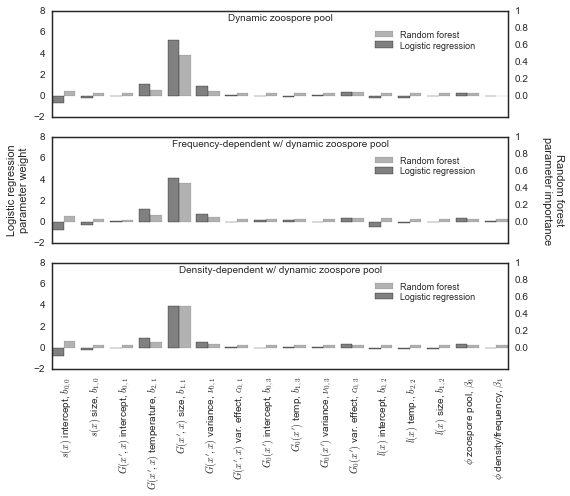

In [9]:
# Make some figures of the coefficients
fig, axes = plt.subplots(3, 1, figsize=(8, 7), sharex=True, sharey=True)
axes = axes.ravel()
trans_fxns = ["Dynamic zoospore pool", "Frequency-dependent w/ dynamic zoospore pool", 
             "Density-dependent w/ dynamic zoospore pool"]
labels = [r"$s(x)$ intercept, $b_{0, 0}$",
          r"$s(x)$ size, $b_{1, 0}$",
          r"$G(x', x)$ intercept, $b_{0, 1}$",
          r"$G(x', x)$ temperature, $b_{2, 1}$",
          r"$G(x', x)$ size, $b_{1, 1}$",
          r"$G(x', x)$ variance, $\nu_{0, 1}$",
          r"$G(x', x)$ var. effect, $c_{0, 1}$",
          r"$G_0(x')$ intercept, $b_{0, 3}$",
          r"$G_0(x')$ temp, $b_{1, 3}$", 
          r"$G_0(x')$ variance, $\nu_{0, 3}$",
          r"$G_0(x')$ var. effect, $c_{0, 3}$",
          r"$l(x)$ intercept, $b_{0, 2}$",
          r"$l(x)$ temp., $b_{2, 2}$",
          r"$l(x)$ size, $b_{1, 2}$", 
          r"$\phi$ zoospore pool, $\beta_0$", r"$\phi$ density/frequency, $\beta_1$"]

trans_labels = [[r"FDCE, $b_0$", "FDCE, $b_1$"], [r"DDCE, $b_0$", "DDCE, $b_1$"], 
                                   [r"DDTZ, $b_0$", "DDTZ, $b_1$"]]

for i, (a, col, ax, t) in enumerate(zip(best_mods_lg, cols, axes, trees)):
    
    #tlabs = labels + trans_labels[i]
    ax2 = ax.twinx()
    vals = a.get_params()['clf'].coef_.ravel()
    rf_vals = t.feature_importances_
    
    if(i == 0):
        vals = np.r_[vals, [0]]
        rf_vals = np.r_[rf_vals, [0]]
    
    ax.bar(range(len(vals)), vals, width=0.4, tick_label=labels, color="grey", label="Logistic regression")
    ax2.bar(np.arange(len(vals)) + 0.4, rf_vals, width=0.4, tick_label=labels, 
                        color="black", alpha=0.3, label="Random forest")
    
    ax.set_ylim(-2, 8)
    ax2.set_ylim(-0.25, 1) # For 0.1
    # ax2.set_ylim(-0.25, 1) # For 0.2
    # ax2.set_ylim(-0.25, 1) # For sigma = 0.3
    # ax2.set_ylim(-0.29, 1) # For 0.4
    #ax2.set_ylim(-0.33, 1) # For 0.5
    ax2.set_yticklabels(["", "", "0.0", "0.2", "0.4", "0.6", "0.8", "1", ""])
    
    ax.set_xticks(np.arange(len(vals)) + 0.5)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90, size=10)
    #ax.set_xticklabels(ax.get_xticklabels(), rotation=90, size=12)
    ax.tick_params(right=None, top=None, left=True)
    
    #if ax.is_last_row():
    #    ax.set_xlabel("Vital rate parameters")
    
    if i == 1:
        ax.set_ylabel("Logistic regression\nparameter weight")
        ax2.set_ylabel("Random forest\nparameter importance", rotation=270, labelpad=35)
    
    ax.text(0.5, 0.91, trans_fxns[i], size=10, ha="center", transform=ax.transAxes)
    ax.legend(loc=(0.7, 0.6), prop={'size':9}, frameon=False)
    ax2.legend(loc=(0.7, 0.7), prop={'size':9}, frameon=False)

fig.subplots_adjust(hspace=0.2)
fig.tight_layout()
plt.savefig("../../results/param_weights_{0}.pdf".format(str(sigma).replace(".", "_")))

---

### Same analysis as above, but now using the  but now using the uncertainty in the parameter estimates themselves

Using regularized logistic regression and a Gradient Boosting Regression Classifier. Interestingly though, the boosted regression trees seem to do much worse than the logistic regression. The pruned regression trees give consistent results with the logistic regression. Interactions between growth and survival functions are the most important.


In [64]:
# Load the data
transmission_fxns = ["zoospore_pool_infection_const",
            "zoospore_pool_infection_fd",
            "zoospore_pool_infection_dd"]
sigma = 0.3

# Building logistic regression classifier
pipe_lg = Pipeline([('scl', StandardScaler()), ('clf', LogisticRegression(random_state=1, penalty="l2"))])\
# This is the best model after cross validation!
param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
param_grid = {'clf__C' : param_range}
gs = GridSearchCV(estimator=pipe_lg,
                  param_grid=param_grid,
                  scoring="accuracy",
                  cv=5,
                  n_jobs=2)

pipe_br = Pipeline([('clf', GradientBoostingClassifier(learning_rate=0.01, max_depth=2))])
param_range_bs = [1000] #[100, 1000, 5000, 10000]
param_grid_bs = {'clf__n_estimators':param_range_bs}
gs_boost = GridSearchCV(estimator=pipe_br,
                        param_grid=param_grid_bs,
                        cv=5,
                       n_jobs=2)


best_mods_lg = []
best_mods_br = []
lg_scores = []
br_scores = []
cols = []
trees = []
preds = []

for trans in transmission_fxns:
    
    dat = pd.read_csv("../../results/sens_results_{0}_bayesian.csv".format(trans))
    cols.append(dat.columns[1:-1])
    X = dat.iloc[:, 1:-1].values
    y = dat.iloc[:, -1].values
    preds.append(dat.iloc[:, 1:-1])
    
    # Drop nan 
    X = X[~np.isnan(y), :]
    y = y[~np.isnan(y)]
    

    # Fit Logistic regression model
    gs = GridSearchCV(estimator=pipe_lg,
                  param_grid=param_grid,
                  scoring="accuracy",
                  cv=5,
                  n_jobs=2)
    gs.fit(X, y)
    
    gs_boost = GridSearchCV(estimator=pipe_br,
                        param_grid=param_grid_bs,
                        cv=5,
                        n_jobs=2)
    gs_boost.fit(X, y)

    print(gs.best_params_)
    print(gs_boost.best_params_)
    lg_scores.append(gs.best_score_)
    br_scores.append(gs_boost.best_score_)

    best_mods_lg.append(gs.best_estimator_) 
    best_mods_br.append(gs_boost.best_estimator_)

    print("{0}, proportion persisting: {1}".format(trans, np.float(np.sum(y == 0)) / len(y)))

{'clf__C': 1.0}
{'clf__n_estimators': 1000}
zoospore_pool_infection_const, proportion persisting: 0.44
{'clf__C': 1.0}
{'clf__n_estimators': 1000}
zoospore_pool_infection_fd, proportion persisting: 0.423
{'clf__C': 10.0}
{'clf__n_estimators': 1000}
zoospore_pool_infection_dd, proportion persisting: 0.464


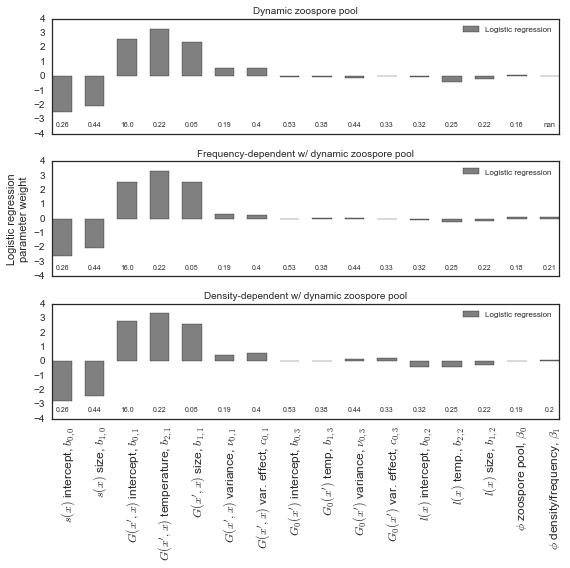

In [74]:
# Make some figures of the coefficients
fig, axes = plt.subplots(3, 1, figsize=(8, 8), sharex=True, sharey=True)
axes = axes.ravel()
#axes = axes.ravel()
trans_fxns = ["Dynamic zoospore pool", "Frequency-dependent w/ dynamic zoospore pool", 
             "Density-dependent w/ dynamic zoospore pool"]
labels = [r"$s(x)$ intercept, $b_{0, 0}$",
          r"$s(x)$ size, $b_{1, 0}$",
          r"$G(x', x)$ intercept, $b_{0, 1}$",
          r"$G(x', x)$ temperature, $b_{2, 1}$",
          r"$G(x', x)$ size, $b_{1, 1}$",
          r"$G(x', x)$ variance, $\nu_{0, 1}$",
          r"$G(x', x)$ var. effect, $c_{0, 1}$",
          r"$G_0(x')$ intercept, $b_{0, 3}$",
          r"$G_0(x')$ temp, $b_{1, 3}$", 
          r"$G_0(x')$ variance, $\nu_{0, 3}$",
          r"$G_0(x')$ var. effect, $c_{0, 3}$",
          r"$l(x)$ intercept, $b_{0, 2}$",
          r"$l(x)$ temp., $b_{2, 2}$",
          r"$l(x)$ size, $b_{1, 2}$", 
          r"$\phi$ zoospore pool, $\beta_0$", r"$\phi$ density/frequency, $\beta_1$"]

trans_labels = [[r"FDCE, $b_0$", "FDCE, $b_1$"], [r"DDCE, $b_0$", "DDCE, $b_1$"], 
                                   [r"DDTZ, $b_0$", "DDTZ, $b_1$"]]

# CVs for vital rate function parameters from the temperature experiment
cvs_base = [0.26, 0.44, 16, 0.22, 0.05, 0.19, 0.40, 0.53, 0.38, 0.44, 0.33, 0.32, 0.25, 0.22]

# CVs for the transmission function parameters for the three transmission functions
cvs_trans = [[0.16, np.nan], [0.18, 0.21], [0.19, 0.20]]

for i, (ax, a, col, t) in enumerate(zip(axes, best_mods_lg, cols, best_mods_br)):
    
        
    #tlabs = labels + trans_labels[i]
    #ax2 = ax.twinx()
    vals = a.get_params()['clf'].coef_.ravel()
    rf_vals = t._final_estimator.feature_importances_

    if(i == 0):
        vals = np.r_[vals, [0]]
        rf_vals = np.r_[rf_vals, [0]]

    ax.bar(range(len(vals)), vals, width=0.6, tick_label=labels, color="grey", label="Logistic regression")
    
    for j, cv_val in enumerate(np.r_[cvs_base, cvs_trans[i]]):
        ax.text(j + 0.3, -3.5, "{0}".format(cv_val), size=7, ha="center")
        
    ax.set_xticks(np.arange(len(vals)) + 0.5)
    #ax.set_xticklabels(ax.get_xticklabels(), rotation=65, size=6)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90, size=12)
    ax.tick_params(right=None, top=None, left=True)

    #if ax.is_last_row():
    #    ax.set_xlabel("Vital rate parameters")

    if i == 1:
        ax.set_ylabel("Logistic regression\nparameter weight")
        #ax2.set_ylabel("Random forest\nparameter importance", rotation=270, labelpad=35)

    #ax.text(0.5, 0.91, trans_fxns[i], size=8, ha="center", transform=ax.transAxes)
    ax.set_title(trans_fxns[i], size=10)
    ax.legend(loc="upper right", prop={'size':8}, frameon=False)
    ax.set_ylim(-4, 4)
    #ax2.legend(loc="upper right", prop={'size':8}, frameon=False)

fig.subplots_adjust(hspace=0.2)
fig.tight_layout()
plt.savefig("../../results/param_weights_bayesian.pdf")

## Plot the extinction curves from the stochastic simulations of the hybrid model

Uses the data produced from the script `stochastic_multiseason_simulation.R` and `zdecay_plots.R` to plot the corresponding extinction curves for the different transmission functions used. 

In [19]:
%load_ext rpy2.ipython

In [20]:
%R -o res res=readRDS("../../results/extinction_simulations_full_bayes.rds")

<ListVector - Python:0x1172aa0e0 / R:0x11ab84c90>
[ListVector, ListVector, ListVector]
<ListVector - Python:0x1172aa0e0 / R:0x11ab84c90>
[ListVector, ListVector, ListVector]
<ListVector - Python:0x1172aa0e0 / R:0x11ab84c90>
[ListVector, ListVector, ListVector]
<ListVector - Python:0x1172aa0e0 / R:0x11ab84c90>
[ListVector, ListVector, ListVector]

In [28]:
# Load in zoospore decay results
zdecay_dat = pd.read_csv("../../results/zsurv_high_traj.csv")
zdecay_dat.columns

Index([u'years', u'means', u'zoospore_decay'], dtype='object')

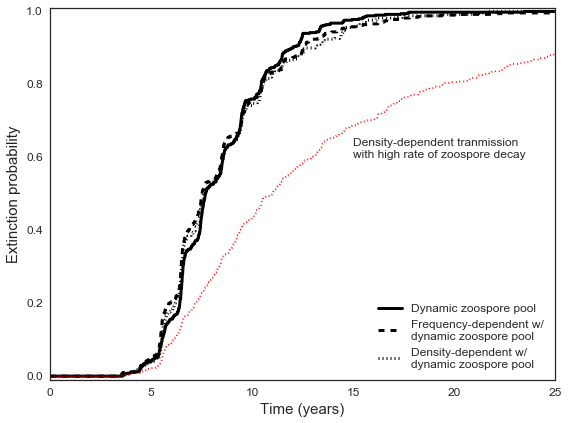

In [32]:
# Make extinction plot
import scipy.stats as stats

fig, axes = plt.subplots(1, 1, figsize=(8, 6), sharey=True)
axes = [axes]

trans_fxns = ["Dynamic zoospore pool", "Frequency-dependent w/\ndynamic zoospore pool", 
             "Density-dependent w/\ndynamic zoospore pool"]
linestyles = ['-', '--', ':']
year_probs = {}

for i, (trans, r) in enumerate(zip(trans_fxns, res)):
    
    years = np.array(r[0])
    probs = np.array(r[1])
    
    years_annual = np.array(ra[0])
    probs_annual = np.array(ra[1])
    axes[0].plot(years, probs, color="black", ls=linestyles[i], label=trans, lw=3)
    #axes[0].plot(years_annual, probs_annual, color="red", ls=linestyles[i])
    
    
    year_probs[trans_fxns[i]] = np.array(uc)[:, 16]
    
    

axes[0].legend(loc="lower right", frameon=False, prop={'size':12})
axes[0].tick_params(right=None, top=None)
axes[0].set_ylabel("Extinction probability", size=15)
axes[0].set_xlabel("Time (years)", size=15)
axes[0].tick_params(labelsize=12)
axes[0].set_ylim(-0.01, 1.01)

plt.xlim(0, 25)
plt.tight_layout()
plt.savefig("../../results/simulated_extinction_plot.pdf")

axes[0].plot(zdecay_dat.years, zdecay_dat.means, ':', color="red")
axes[0].text(15, 0.6, "Density-dependent tranmission\nwith high rate of zoospore decay", size=12)
plt.savefig("../../results/simulated_extinction_plot_w_decay.pdf")

## Plotting the various vital rate functions from the laboratory temperature experiment

These plots are given in `../docs/ipm_extinction_appendix.pdf`.

In [6]:
%load_ext rpy2.ipython

/Users/mqwilber/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: Matrix

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/Users/mqwilber/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 
Attaching package: ‘nlme’


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/Users/mqwilber/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following object is masked from ‘package:lme4’:

    lmList


  res = super(Function, self).__call__(*new_args, **new_kwargs)


[1] "Dropping 4 points"
[1] "Dropping 3 points"
[1] "Dropping 4 points"
[1] "Dropping 3 points"


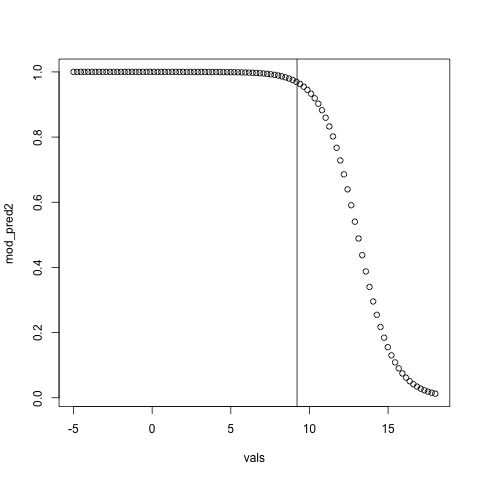

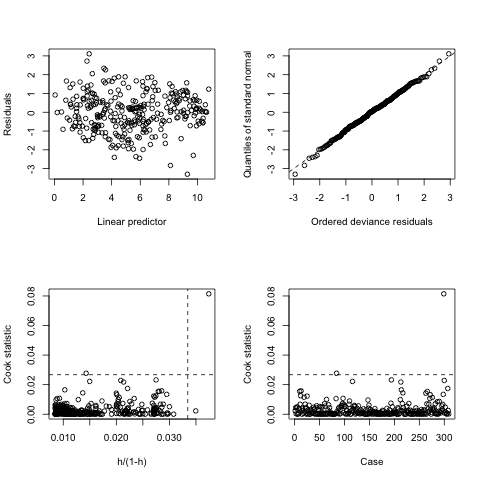

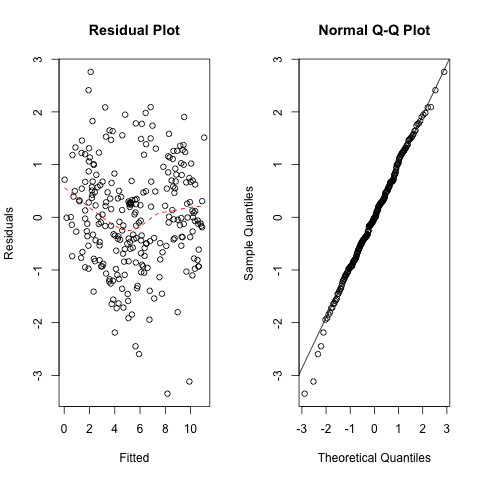

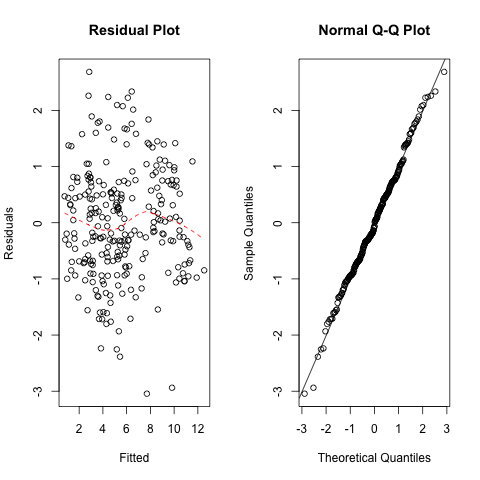

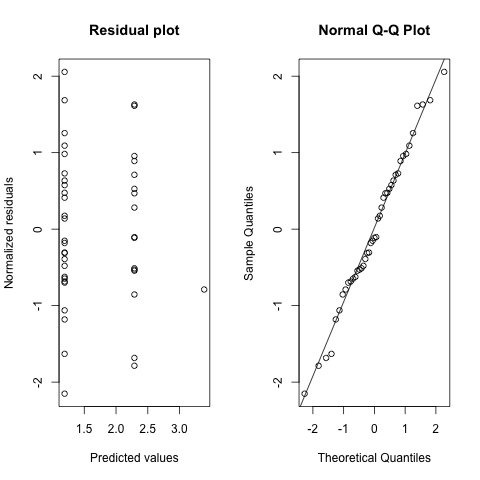

In [7]:
%%R
# Source the file fitting the temperature dependent data
source("ipm_vital_rate_parameter_analysis.R")

In [8]:
%R -o temp_data_no_26_nozeros_nona temp_data_no_26_nozeros_nona

,size,sizeNext,time,individual,temp,surv,stage,temp_fact
2,2.268408,3.298500,3,F4_1,4,1,adult,4 C
3,3.298500,1.090580,3,F4_1,4,1,adult,4 C
20,1.760613,1.197552,3,F4_1,4,1,adult,4 C
21,1.197552,-0.433865,3,F4_1,4,1,adult,4 C
22,-0.433865,1.807633,3,F4_1,4,1,adult,4 C
25,1.598175,1.599792,3,F4_1,4,1,adult,4 C
26,1.599792,1.950471,3,F4_1,4,1,adult,4 C
27,1.950471,2.560632,3,F4_1,4,1,adult,4 C
28,2.560632,0.639746,3,F4_1,4,1,adult,4 C
29,0.639746,4.015446,3,F4_1,4,1,adult,4 C


In [9]:
%R -o bayes_fit bayes_fit=readRDS("../../results/bayesian_parameter_estimates.rds")

<ListVector - Python:0x117c18320 / R:0x123b14160>
[Float..., Float..., DataF..., ..., Float..., Float..., Float...]
  surv_int: <class 'rpy2.robjects.vectors.FloatVector'>
  <FloatVector - Python:0x117a54248 / R:0x126cd4b08>
[5.273111]
  surv_slope: <class 'rpy2.robjects.vectors.FloatVector'>
  <FloatVector - Python:0x117a542d8 / R:0x126cd4b38>
[-2.573244]
<ListVector - Python:0x117c18320 / R:0x123b14160>
[Float..., Float..., DataF..., ..., Float..., Float..., Float...]
  ...
  surv_int: <class 'rpy2.robjects.vectors.FloatVector'>
  <FloatVector - Python:0x117a54170 / R:0x126cd4488>
[0.999137]
  surv_slope: <class 'rpy2.robjects.vectors.FloatVector'>
  <FloatVector - Python:0x117a545f0 / R:0x126cd44b8>
[-1.660243]
  surv_samples: <class 'rpy2.robjects.vectors.FloatVector'>
  <FloatVector - Python:0x117a545a8 / R:0x126cd44e8>
[0.101897]

In [10]:
# Extract param names
param_names = np.array(bayes_fit.names)
param_names

array(['surv_int', 'surv_slope', 'surv_samples', 'surv_mean', 'surv_sd',
       'growth_int', 'growth_size', 'growth_temp', 'growth_sigma2',
       'growth_sigma2_exp', 'growth_samples', 'clump_int', 'clump_temp',
       'clump_sigma2', 'clump_sigma2_exp', 'clump_samples', 'loss_int',
       'loss_size', 'loss_temp', 'loss_samples', 'dd_intercept',
       'dd_slope', 'dd_samples', 'fd_intercept', 'fd_slope', 'fd_samples',
       'zfd_intercept', 'zfd_slope', 'zfd_samples', 'zdd_intercept',
       'zdd_slope', 'zdd_samples', 'zconst_intercept', 'zconst_samples',
       'class_zero_surv', 'prob_inf_int', 'prob_inf_temp'], 
      dtype='|S17')

**Plot the temperature dependent growth function**

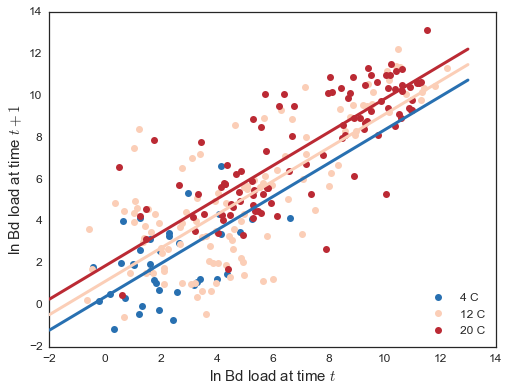

In [38]:
import scipy.stats as stats

# Extract growth data
growth_data = temp_data_no_26_nozeros_nona

# Get mean growth params
param_names = np.array(bayes_fit.names)
gint = bayes_fit[np.where(param_names == "growth_int")[0][0]][0]
gslope = bayes_fit[np.where(param_names == "growth_size")[0][0]][0]
gtemp = bayes_fit[np.where(param_names == "growth_temp")[0][0]][0]

sns_colors = sns.color_palette("RdBu", n_colors=7)
colors = [sns_colors[-1], sns_colors[2], sns_colors[0]] #['white', '#B8B8B8', 'black'] #[col['color'] for col in plt.rcParams['axes.prop_cycle']]

# Range of Bd loads to explore
vals = np.linspace(-2, 13, num=20)


fig, ax = plt.subplots(1, 1, figsize=(8, 6))


# Loop through and plot each temp
for i, gdata in enumerate(growth_data.groupby("temp")):
    
    temp = gdata[0]
    tdat = gdata[1]
    ax.plot(tdat['size'], tdat['sizeNext'], 'o', color=colors[i], label='{0} C'.format(temp))
    pred = gint + gslope*vals + gtemp*temp
    
    ax.plot(vals, pred, color=colors[i], lw=3, zorder=20)

#ax.plot(vals, vals, '--', color="black", zorder=-3, alpha=0.6)

# Add uncertainty in parameters
uncert = np.array(bayes_fit[np.where(param_names == "growth_samples")[0][0]])

for i, temp in enumerate(np.unique(growth_data.temp)):
    
    lower_vals = []
    upper_vals = []
    
    for val in vals:
        tpred = uncert[0, :] + uncert[1, :]*val + uncert[2, :]*temp
        lower, upper = stats.scoreatpercentile(tpred, (2.5, 97.5))
        lower_vals.append(lower)
        upper_vals.append(upper)

    #ax.fill_between(vals, lower_vals, upper_vals, color=colors[i], alpha=0.1)

ax.set_xlabel(r"ln Bd load at time $t$", size=15)
ax.set_ylabel(r"ln Bd load at time $t + 1$", size=15)
ax.legend(loc="lower right", prop={'size':12}, frameon=False)
ax.tick_params(right=None, top=None, labelsize=12)
#plt.tight_layout()
plt.savefig("../../results/vital_plots/growth_fxn.pdf")
    
    

# survint = bayes_fit[np.where(param_names == "surv_int")[0][0]][0]
# survslope = bayes_fit[np.where(param_names == "surv_slope")[0][0]][0]
# survmean = bayes_fit[np.where(param_names == "surv_mean")[0][0]][0]
# survsd = bayes_fit[np.where(param_names == "surv_sd")[0][0]][0]

# transvals = (vals - survmean) / survsd
# probs = 1 / (1 + np.exp(-1*(survint + survslope*transvals)))

# ax2 = ax.twinx()
# ax2.plot(vals, probs)

In [12]:
%R -o surv_data surv_data=temp_data_no_26_nozeros[temp_data_no_26_nozeros['temp'] == 20, ]

,size,sizeNext,time,individual,temp,surv,stage,temp_fact
388,1.477962,4.563431,3,F20_1,20,1,adult,20 C
389,4.563431,4.690614,3,F20_1,20,1,adult,20 C
390,4.690614,6.239496,3,F20_1,20,1,adult,20 C
391,6.239496,9.515893,3,F20_1,20,1,adult,20 C
392,9.515893,10.974602,3,F20_1,20,1,adult,20 C
393,10.974602,9.305207,3,F20_1,20,1,adult,20 C
394,9.305207,8.717967,3,F20_1,20,1,adult,20 C
395,8.717967,9.896938,3,F20_1,20,1,adult,20 C
396,9.896938,9.754829,3,F20_1,20,1,adult,20 C
397,9.754829,10.644022,3,F20_1,20,1,adult,20 C


**Plot the survival function**

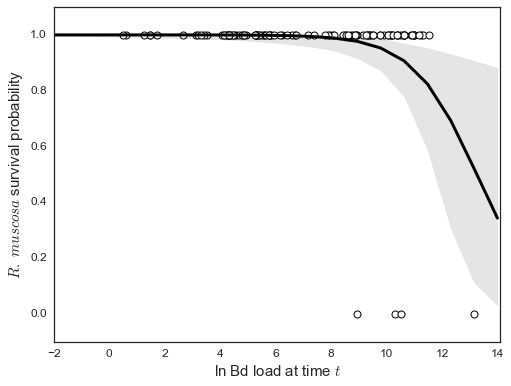

In [13]:
# Plot survival function
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(surv_data['size'], surv_data.surv, 'o', color="white", mew=1, mec="black", label="Laboratory data")
ax.set_ylim((-0.1, 1.1))
ax.set_xlim(-2, 14.1)

# Predicted surv_prob
vals = np.linspace(-2, 14, num=20)

survint = bayes_fit[np.where(param_names == "surv_int")[0][0]][0]
survslope = bayes_fit[np.where(param_names == "surv_slope")[0][0]][0]
survmean = bayes_fit[np.where(param_names == "surv_mean")[0][0]][0]
survsd = bayes_fit[np.where(param_names == "surv_sd")[0][0]][0]

transvals = (vals - survmean) / survsd
probs = 1 / (1 + np.exp(-1*(survint + survslope*transvals)))

# Plot predicted
ax.plot(vals, probs, color="black", lw=3, label="Model fit")

# Get uncertainty
lower_vals = []
upper_vals = []
surv_samples = np.array(bayes_fit[np.where(param_names == "surv_samples")[0][0]])

for val in transvals:
    pred_probs = 1 / (1 + np.exp(-1*(surv_samples[0, :] + surv_samples[1, :]*val)))
    lower, upper = stats.scoreatpercentile(pred_probs, (2.5, 97.5))
    lower_vals.append(lower)
    upper_vals.append(upper)
    
ax.fill_between(vals, lower_vals, upper_vals, color="black", alpha=0.1)
ax.set_xlabel(r"ln Bd load at time $t$", size=15)
ax.set_ylabel(r"$R.$ $muscosa$ survival probability", size=15)
ax.tick_params(right=None, top=None, labelsize=12)
#ax.legend(frameon=False, loc="lower left")
#plt.tight_layout()
plt.savefig("../../results/vital_plots/survival_fxn.pdf")


In [14]:
%R -o loss_data loss_data=alive_trun_no_26

,size,sizeNext,time,individual,temp,surv,stage,loss
2,2.268408,3.298500,3,F4_1,4,1,adult,0
3,3.298500,1.090580,3,F4_1,4,1,adult,0
4,1.090580,0.000000,3,F4_1,4,1,adult,1
8,0.888714,0.000000,3,F4_1,4,1,adult,1
11,0.141500,0.000000,3,F4_1,4,1,adult,1
14,1.912206,0.000000,3,F4_1,4,1,adult,1
16,1.040983,0.000000,3,F4_1,4,1,adult,1
20,1.760613,1.197552,3,F4_1,4,1,adult,0
21,1.197552,-0.433865,3,F4_1,4,1,adult,0
22,-0.433865,1.807633,3,F4_1,4,1,adult,0


**Plot the loss of infection function**

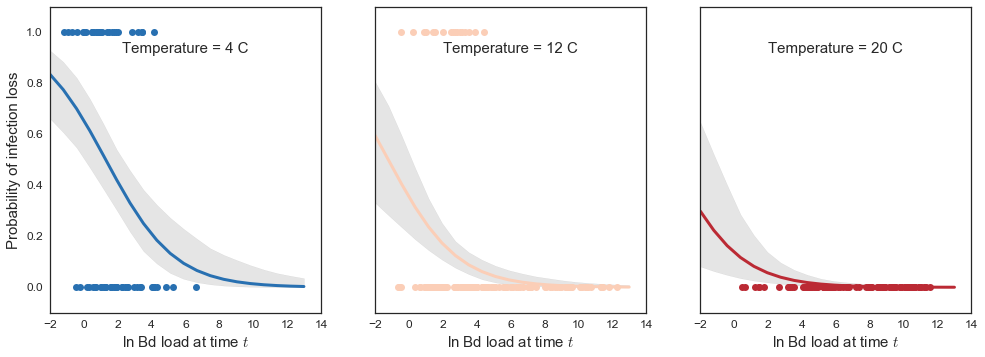

In [40]:
# Plot the loss of infection function
import scipy.stats as stats
lint = bayes_fit[np.where(param_names == "loss_int")[0][0]][0]
lslope = bayes_fit[np.where(param_names == "loss_size")[0][0]][0]
ltemp = bayes_fit[np.where(param_names == "loss_temp")[0][0]][0]

sns_colors = sns.color_palette("RdBu", n_colors=7)
colors = [sns_colors[-1], sns_colors[2], sns_colors[0]]

# Range of Bd loads to explore
vals = np.linspace(-2, 13, num=20)


fig, axes = plt.subplots(1, 3, figsize=(16, 5), sharey=True, sharex=True)
axes = axes.ravel()


# Loop through and plot each temp
for i, ldata in enumerate(loss_data.groupby("temp")):
    
    temp = ldata[0]
    tdat = ldata[1]
    axes[i].plot(tdat['size'], tdat['loss'], 'o', color=colors[i], alpha=1, label='{0} degree C'.format(temp))
    pred = 1 / (1 + np.exp(-1*(lint + lslope*vals + ltemp*temp)))
    
    axes[i].plot(vals, pred, color=colors[i], lw=3)
    axes[i].tick_params(labelsize=12, right=None, top=None)

# ax.plot(vals, vals, '--', color="black", zorder=-3, alpha=0.6)

# # Add uncertainty in parameters
uncert = np.array(bayes_fit[np.where(param_names == "loss_samples")[0][0]])

for i, temp in enumerate(np.unique(loss_data.temp)):
    
    lower_vals = []
    upper_vals = []
    
    for val in vals:
        tpred =  1 / (1 + np.exp(-1*(uncert[0, :] + uncert[1, :]*val + uncert[2, :]*temp)))
        lower, upper = stats.scoreatpercentile(tpred, (2.5, 97.5))
        lower_vals.append(lower)
        upper_vals.append(upper)

    axes[i].fill_between(vals, lower_vals, upper_vals, color="black", alpha=0.1)
    axes[i].set_ylim(-0.1, 1.1)
    
    if axes[i].is_first_col():
        axes[i].set_ylabel(r"Probability of infection loss", size=15)
        
    axes[i].set_xlabel(r"ln Bd load at time $t$", size=15)
    
    axes[i].text(0.5, 0.85, "Temperature = {0} C".format(temp), size=15, ha="center", transform=axes[i].transAxes)

plt.subplots_adjust(left=0.1, right=0.9, top=0.95, bottom=0.1)
plt.savefig("../../results/vital_plots/loss_infection_fxn.pdf")

In [16]:
%R -o initial_data initial_data=transition_no_26

,size,sizeNext,time,individual,temp,surv,stage
7,0,0.888714,3,F4_1,4,1,adult
10,0,0.141500,3,F4_1,4,1,adult
13,0,1.912206,3,F4_1,4,1,adult
15,0,1.040983,3,F4_1,4,1,adult
19,0,1.760613,3,F4_1,4,1,adult
24,0,1.598175,3,F4_1,4,1,adult
49,0,0.716864,3,F4_2,4,1,adult
69,0,-0.421594,3,F4_2,4,1,adult
84,0,2.858766,3,F4_3,4,1,adult
88,0,0.514021,3,F4_3,4,1,adult


**Plot the gain of infection function**

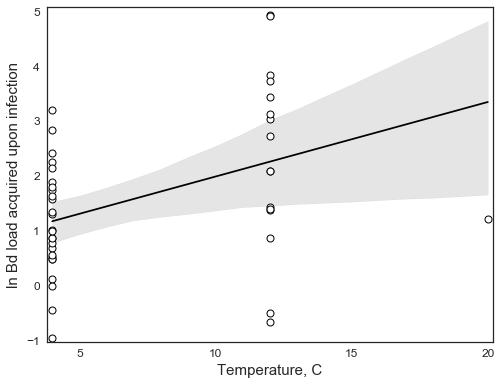

In [18]:

import scipy.stats as stats
clint = bayes_fit[np.where(param_names == "clump_int")[0][0]][0]
cltemp = bayes_fit[np.where(param_names == "clump_temp")[0][0]][0]
clsigma2 = bayes_fit[np.where(param_names == "clump_sigma2")[0][0]][0]
clsigma2_exp = bayes_fit[np.where(param_names == "clump_sigma2_exp")[0][0]][0]

colors = ['blue', 'orange', 'red'] #[col['color'] for col in plt.rcParams['axes.prop_cycle']]

# Range of Bd loads to explore
vals = np.arange(4, 21)#np.linspace(-2, 13, num=20)


fig, ax = plt.subplots(1, 1, figsize=(8, 6), sharey=True, sharex=True)


# Loop through and plot each temp
for i, idata in enumerate(initial_data.groupby("temp")):
    
    temp = idata[0]
    tdat = idata[1]
    ax.plot(tdat['temp'], tdat['sizeNext'], 'o', color="white", mec="black", mew=1, label='{0} degree C'.format(temp))
    
    pred = clint + vals*cltemp
    
ax.plot(vals, pred, color="black")

# ax.plot(vals, vals, '--', color="black", zorder=-3, alpha=0.6)

# # Add uncertainty in parameters
uncert = np.array(bayes_fit[np.where(param_names == "clump_samples")[0][0]])

lower_vals = []
upper_vals = []
    
for val in vals:
    
    tpred = uncert[0, :] + val*uncert[1, :]
    lower, upper = stats.scoreatpercentile(tpred, (2.5, 97.5))
    lower_vals.append(lower)
    upper_vals.append(upper)

ax.fill_between(vals, lower_vals, upper_vals, color="black", alpha=0.1)
ax.set_ylim(-1, 5.1)
ax.set_xlim(3.8, 20.2)
ax.set_xlabel("Temperature, C", size=15)
ax.set_ylabel(r"ln Bd load acquired upon infection", size=15)
ax.tick_params(top=None, right=None, labelsize=12)
plt.savefig("../../results/vital_plots/initial_infection_fxn.pdf")

**Plot zoospore decay function from Woodhams et al. 2008**

In [42]:
%%R

# Double check working directory if this doesn't work
source("../model_analysis/IPM_functions_for_R.R")
temps = 4:28
zprobs = get_zoospore_surv_prob(temps)
emp_temps = c(4, 14.5, 23, 28)
emp_probs = get_zoospore_surv_prob(emp_temps)

In [43]:
%R -o zprobs zprobs

array([ 0.82332851,  0.82379096,  0.82396855,  0.82359153,  0.82239154,
        0.82010377,  0.8164701 ,  0.81124299,  0.8041901 ,  0.79509946,
        0.78378522,  0.77000067,  0.75145927,  0.72416629,  0.6849132 ,
        0.63189222,  0.56520579,  0.48716063,  0.40214772,  0.31600413,
        0.23560542,  0.16804978,  0.11595017,  0.07825392,  0.05223513])

In [44]:
%R -o emp_probs emp_probs

array([ 0.82332851,  0.77724474,  0.31600413,  0.05223513])

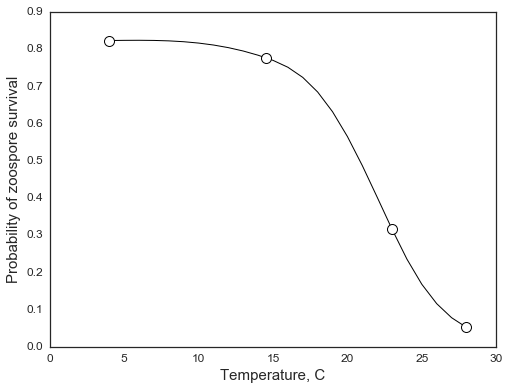

In [45]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
temps = np.arange(4, 29)

ax.plot(temps, zprobs, lw=1, color="black", label="Spline prediction")
ax.plot([4, 14.5, 23, 28], emp_probs, 'o', ms=10, color='white', mec="black", mew=1, label="Laboratory data from Woodhams $et$ $al.$ (2008)")

ax.set_xlabel("Temperature, C", size=15)
ax.set_ylabel("Probability of zoospore survival", size=15)
ax.tick_params(top=None, right=None, labelsize=12)
#ax.legend(loc="lower left")

plt.savefig("../../results/vital_plots/zoospore_decay_fxn.pdf")

### Plot the data from the mesocom transmission experiment

In [46]:
%%R

dat = read.csv("../../data/formatted/formatted_dd_data.csv", header=T)
short_dat = dat[dat$Day < 35, ] # Before the crash

# Only look at transitions with times between 4 and 8 days
short_dat = short_dat[(short_dat$time > 3) & (short_dat$time < 9), ]
short_dat = short_dat[complete.cases(short_dat), ] # Drop NAs
short_dat$time_ratio = short_dat$time #/ min(short_dat$time)

# Subset to get the transmission data. 0 -> infected/not infected
trans_data = short_dat[short_dat$size == 0, ]
trans_data$pa = as.integer(trans_data$sizeNext > 0)
trans_data = droplevels(trans_data)

In [47]:
%R -o trans_data trans_data

,size,sizeNext,swab_id,time,Day,individual,density,weight,svl,sex,ze_tadpoles,tank_num,ze_frogs,num_infected,cum_ze_frogs,cum_ze_tadpoles,time_ratio,pa
1,0,0.000,MDF10_1_Jul25,5,5,MDF10_1,16,6.7,42.4,F,3580.200,10,0.000,0,0.000,3580.200,5,0
2,0,0.000,MDF10_1_Jul31,6,11,MDF10_1,16,7.3,44,F,355.184,10,0.000,0,0.000,3935.384,6,0
3,0,3.776,MDF10_1_AUG7,7,18,MDF10_1,16,6.4,41.4,F,12.184,10,0.000,0,0.000,3947.568,7,1
12,0,0.000,MDF10_2_Jul25,5,5,MDF10_2,16,7.6,42.1,M,3580.200,10,0.000,0,0.000,3580.200,5,0
13,0,0.000,MDF10_2_Jul31,6,11,MDF10_2,16,7.9,42.7,M,355.184,10,0.000,0,0.000,3935.384,6,0
14,0,4.904,MDF10_2_AUG7,7,18,MDF10_2,16,6.7,41,M,12.184,10,0.000,0,0.000,3947.568,7,1
24,0,0.000,MDF10_3_Jul25,5,5,MDF10_3,16,7.1,41.8,F,3580.200,10,0.000,0,0.000,3580.200,5,0
25,0,0.000,MDF10_3_Jul31,6,11,MDF10_3,16,7.1,41,F,355.184,10,0.000,0,0.000,3935.384,6,0
26,0,1.936,MDF10_3_AUG7,7,18,MDF10_3,16,6.5,41.5,F,12.184,10,0.000,0,0.000,3947.568,7,1
36,0,0.000,MDF10_4_Jul25,5,5,MDF10_4,16,7.5,43.3,M,3580.200,10,0.000,0,0.000,3580.200,5,0


In [48]:
trans_data.ix[:, "prop_inf"] = trans_data.num_infected / trans_data.density
fd_res = trans_data.groupby("prop_inf")['pa'].aggregate({"avg" : np.mean, "num_points": len})
dd_res = trans_data.groupby("num_infected")['pa'].aggregate({"avg" : np.mean, "num_points": len})

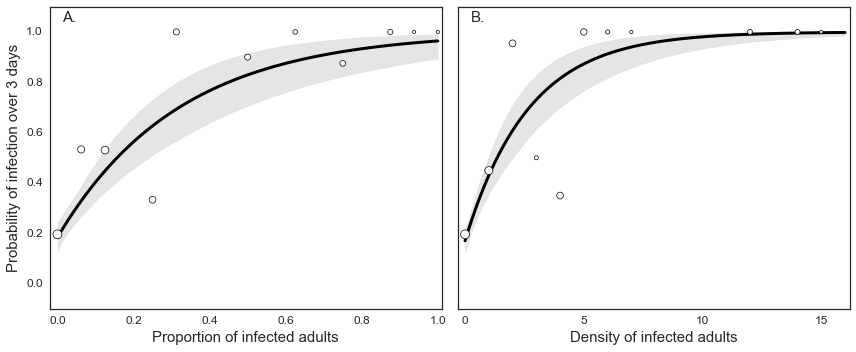

In [59]:
import scipy.stats as stats
fd_int = bayes_fit[np.where(param_names == "zfd_intercept")[0][0]][0]
fd_slope = bayes_fit[np.where(param_names == "zfd_slope")[0][0]][0]
labsize = 15
ticksize= 12
lz=7
time=5


fig, axes = plt.subplots(1, 2, figsize = (12, 5), sharey=True)
axes = axes.ravel()
for ax in axes:
    ax.tick_params(top=None, right=None, labelsize=ticksize)

vals = np.linspace(0, 1, num=100)
preds = 1 - exp(-time*(fd_int*lz + fd_slope*vals))
axes[0].plot(vals, preds, color="black", lw=3)

# Uncertainty
uncert = np.array(bayes_fit[np.where(param_names == "zfd_samples")[0][0]])

lower_vals = []
upper_vals = []
    
for val in vals:
    
    tpred = 1 - exp(-time*(uncert[0, :]*lz + uncert[1, :]*val))
    
    lower, upper = stats.scoreatpercentile(tpred, (2.5, 97.5))
    lower_vals.append(lower)
    upper_vals.append(upper)

axes[0].fill_between(vals, lower_vals, upper_vals, color="black", alpha=0.1)
axes[0].set_ylim(-0.1, 1.1)
# ax.set_xlim(3.8, 20.2)
axes[0].set_xlabel("Proportion of infected adults", size=labsize)
axes[0].set_ylabel("Probability of infection over 3 days", size=labsize)
#axes[0].text(0.5, 0.2, "Frequency dependent w/\ndynamic zoospore pool", size=labsize, ha='center', transform=axes[0].transAxes)
axes[0].text(0.05, 0.95, "A.", ha='center', size=labsize, transform=axes[0].transAxes)


# Plot Density-dependence


dd_int = bayes_fit[np.where(param_names == "zdd_intercept")[0][0]][0]
dd_slope = bayes_fit[np.where(param_names == "zdd_slope")[0][0]][0]

vals = np.linspace(0, 16, num=100)
preds = 1 - exp(-time*(dd_int*lz + dd_slope*vals))
axes[1].plot(vals, preds, lw=3, color="black", ls="-")

# Uncertainty
uncert = np.array(bayes_fit[np.where(param_names == "zdd_samples")[0][0]])

lower_vals = []
upper_vals = []
    
for val in vals:
    
    tpred = 1 - exp(-time*(uncert[0, :]*lz + uncert[1, :]*val))
    
    lower, upper = stats.scoreatpercentile(tpred, (2.5, 97.5))
    lower_vals.append(lower)
    upper_vals.append(upper)

axes[1].fill_between(vals, lower_vals, upper_vals, color="black", alpha=0.1)
axes[1].set_ylim(-0.1, 1.1)
# ax.set_xlim(3.8, 20.2)
axes[1].set_xlabel("Density of infected adults", size=labsize)
#axes[1].text(0.5, 0.2, "Density dependent w/\ndynamic zoospore pool", size=labsize, ha='center', transform=axes[1].transAxes)
axes[1].text(0.05, 0.95, "B.", ha='center', size=labsize, transform=axes[1].transAxes)

axes[0].scatter(fd_res.index, fd_res.avg, s=log(fd_res.num_points + 1) * 15, edgecolor="black", linewidths=0.7, facecolor="white", zorder=10)
axes[1].scatter(dd_res.index, dd_res.avg, s=log(dd_res.num_points + 1) * 15, edgecolor="black", linewidths=0.7, facecolor="white", zorder=10)
axes[0].set_xlim(-0.02, 1.01)
axes[1].set_xlim(-0.3, 16.2)

plt.tight_layout()
plt.savefig("../../results/vital_plots/transmission_fxns.pdf")

# Get classification errors

#fd_preds = 1 - exp(-(fd_int*trans_data.time_ratio + fd_slope*trans_data.prop_inf*trans_data.time_ratio))
#dd_preds = 1 - exp(-(dd_int*trans_data.time_ratio + dd_slope*trans_data.num_infected*trans_data.time_ratio))
#ddz_preds = 1 - exp(-(z_int*trans_data.time_ratio*trans_data.tot_ze + z_slope*trans_data.num_infected*trans_data.time_ratio))


## Conceptual plot of interaction between growth and survival function

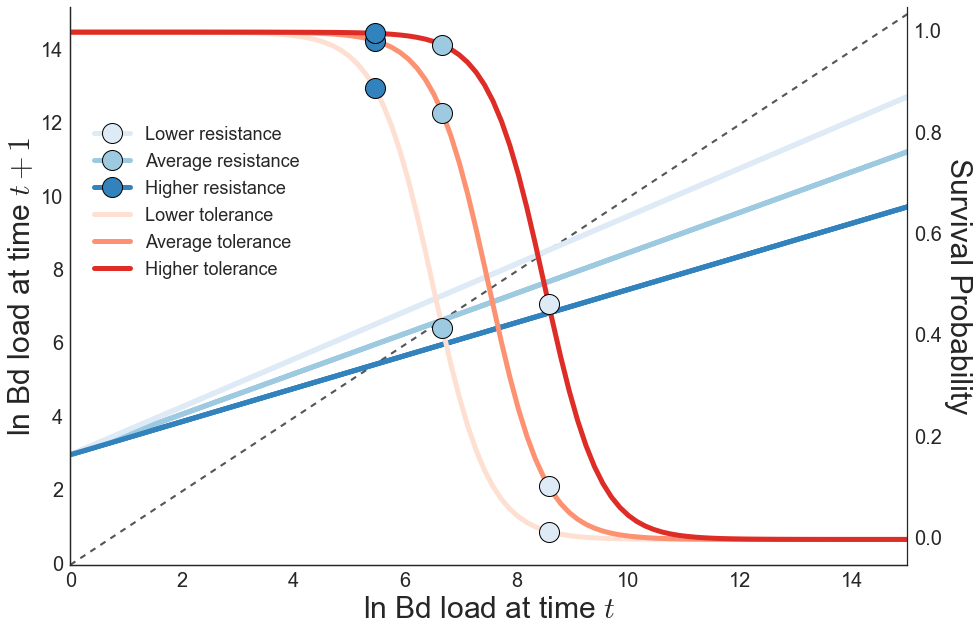

In [3]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

colors = ['#deebf7','#9ecae1','#3182bd']#["black", "#808080", "#D0D0D0"]
surv_ints = [13.0, 15.0, 17]#15.0 / 8]
surv_slopes = [-2.0, -2.0, -2.0]#-2.0 / 8]
letters = ["A.", "B.", "C."]
resist = ["Lower", "Average","Higher"]
line_colors = np.array(['#fee0d2','#fc9272','#de2d26'])
handles = []

for i in range(3):

    ax.tick_params(top=None, labelsize=20)
    ax.axes.spines['top'].set_visible(False)
    
    if i == 0:
        ax2 = ax.twinx()
        ax2.tick_params(top=None, labelsize=20)
        ax2.axes.spines['top'].set_visible(False)
    
    if ax.is_last_row():
        ax.set_xlabel("ln Bd load at time $t$", size=30)
    
    ax.set_ylabel("ln Bd load at time $t + 1$", size=30)

    ax2.set_ylabel("Survival Probability", rotation=270, labelpad=30, size=30)
    #ax2.spines['right'].set_visible(False)
    ax.spines['right'].set_visible(False)

    upper_load = 15
    lower_load = 0
    loads = np.linspace(lower_load, upper_load, num=100)
    ax.plot(loads, loads, '--', color='black', alpha=0.3, lw=2)
    ax.set_xlim((lower_load, upper_load))
    ax.set_ylim((lower_load, upper_load + 0.2))
    ax2.set_ylim((-0.05, 1.05))

    # Draw conceptual growth curve
    intercept = 3
    slope = 0.55
    x_cross = intercept / (1 - slope)
    y_cross = slope * x_cross + intercept
    ax.plot(loads, intercept + slope*loads, '-', color=colors[1], lw=5)
    
    if i == 0:
        plt.savefig("../../results/resistance_and_tolerance_conceptual_initial0.pdf")

    pert = 0.1
    ax.plot(loads, intercept + (slope + pert)*loads, '-', color=colors[0], lw=5)
    ax.plot(loads, intercept + (slope - pert)*loads, '-', color=colors[2], lw=5)
    
    if i == 0:
        
        thand = [plt.Line2D([1], [1], linestyle='-', marker="o", lw=5, ms=20, mew=1, color=colors[0], label="Lower resistance"),
                 plt.Line2D([1], [1], linestyle='-', marker='o', lw=5, ms=20, mew=1, color=colors[1], label="Average resistance"),
                 plt.Line2D([1], [1], linestyle='-', marker="o", lw=5,  ms=20, mew=1, color=colors[2], label="Higher resistance")]
        ax.legend(thand, ("Lower resistance", "Average resistance", "Higher resistance"), numpoints=1, prop={'size' : 18}, loc=(0.02, 0.5), frameon=False)
        plt.savefig("../../results/resistance_and_tolerance_conceptual_initial1.pdf")
        ax.legend_.remove()

    x_cross1 = intercept / (1 - (slope + pert))
    y_cross1 = (slope + pert) * x_cross1 + intercept
    x_cross2 = intercept / (1 - (slope - pert))
    y_cross2 = (slope - pert) * x_cross2 + intercept
    
    #ax.plot(x_cross, y_cross, 'o', color=colors[0], ms=20)
    #ax.plot(x_cross1, y_cross1, 'o', color=colors[1], ms=20)
    #ax.plot(x_cross2, y_cross2, 'o', color=colors[2], ms=20)


    amult = 5
    x_start = 5 
    y_start = 2
    #ax.arrow(x_start, y_start, (x_cross - 0.3) - x_start, (y_cross - 1) - y_start, head_width=0.05*amult, head_length=0.1*amult, fc='k', ec='k', lw=2)
    #ax.text(x_start, y_start - 0.3, "Static Bd Load", size=15, ha="center", va="top", zorder=20)



    # Draw conceptual survival curve
    logistic = lambda x, a, b: 1 / (1 + np.exp(-(a + b * x)))
    a = surv_ints[i]; b = surv_slopes[i]
    
    h1 = ax2.plot(x_cross, logistic(x_cross, a, b), '-o', lw=5, ms=20, mew=1, color=colors[1], label="Average resistance")
    h2 = ax2.plot(x_cross1, logistic(x_cross1, a, b), '-o', lw=5, ms=20, mew=1, color=colors[0], label="Lower resistance")
    h3 = ax2.plot(x_cross2, logistic(x_cross2, a, b), '-o', lw=5,  ms=20, mew=1, color=colors[2], label="Higher resistance")
    
    if i == 0:
        handles.append(h2[0])
        handles.append(h1[0])
        handles.append(h3[0])
        #ax2.legend(handles=handles, numpoints=1, prop={'size' : 18}, loc=(0.02, 0.5), frameon=False)
        #plt.savefig("../../results/resistance_and_tolerance_conceptual_initial2.pdf")
        
    
    h0 = ax2.plot(loads, logistic(loads, a, b), lw=5, zorder=-1, color=line_colors[i], label="{0} tolerance".format(resist[i]))
    
    
    handles.append(h0[0])

    ytrans = ax2.transData.inverted().transform(ax.transData.transform((x_cross, y_cross)))[1]
    ytrans1 = ax2.transData.inverted().transform(ax.transData.transform((x_cross1, y_cross1)))[1]
    ytrans2 = ax2.transData.inverted().transform(ax.transData.transform((x_cross2, y_cross2)))[1]
    #ax2.vlines(x_cross, ytrans, logistic(x_cross, a, b), color="black", linestyle=":", lw=5, zorder=1)
    #ax2.vlines(x_cross2, ytrans2, logistic(x_cross2, a, b), linestyle=":", lw=5, zorder=1)
    #ax2.vlines(x_cross1, ytrans1, logistic(x_cross1, a, b), linestyle=":", lw=5, zorder=1)
    #ax2.hlines(logistic(x_cross1, a, b), x_cross1, upper_load, lw=5, linestyle=":")
    #ax2.hlines(logistic(x_cross2, a, b), x_cross2, upper_load, lw=5, linestyle=":")
    #ax2.hlines(logistic(x_cross, a, b), x_cross, upper_load, lw=5, linestyle=":")
    
    #ax2.plot(x_cross, ytrans, 'x', color=colors[1], ms=15, zorder=2)
    #ax2.plot(x_cross1, ytrans1, 'x', color=colors[0], ms=15, zorder=2)
    #ax2.plot(x_cross2, ytrans2, 'x', color=colors[2], ms=15, zorder=2)

    #ax.text(0.02, 0.98, letters[i], size=20, ha="center", transform=ax.transAxes)
    
    ax2.legend(handles=handles, numpoints=1, prop={'size' : 18}, loc=(0.02, 0.5), frameon=False)
    plt.savefig("../../results/resistance_and_tolerance_conceptual_one_plot_{0}.pdf".format(i))
    
ax2.legend(handles=handles, numpoints=1, prop={'size' : 18}, loc=(0.02, 0.5), frameon=False)

#plt.tight_layout()
plt.savefig("../../results/resistance_and_tolerance_conceptual_one_plot.pdf")

## Plot empirical load trajectories from mesocosm experiment

In [5]:
dat = pd.read_csv("../../data/archival/DensExpt.csv")
dat = dat[(dat.Day <= 74) & (dat.lifestage == " adult")]
#dat = dat[(dat.Day <= 32) & (dat.lifestage == " adult")]

In [3]:
dat.columns

Index([u'swab_id', u'Indiv_id', u'Frog_or_Tadpole', u'Tank_num', u'Indiv_num',
       u'InitialFrogs', u'ZE', u'alive', u' site_name', u'date_collected',
       u'Julian', u'Day', u'observer', u'species', u'lifestage',
       u' gosner_stage', u'weight', u'svl', u'sex', u'notes', u'pit_tag',
       u'frog_condition', u'total_wt', u' bag_wt', u'ct0', u'ct1', u'ge0',
       u'ge1', u'avg_ge_score'],
      dtype='object')

In [6]:
dat = dat.sort(columns=['InitialFrogs', 'Tank_num'])
dat.ix[:, "init_tank"] = [str(int(a)) + "_" + str(b) for a, b in zip(dat.InitialFrogs, dat.Tank_num)]

/Users/mqwilber/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


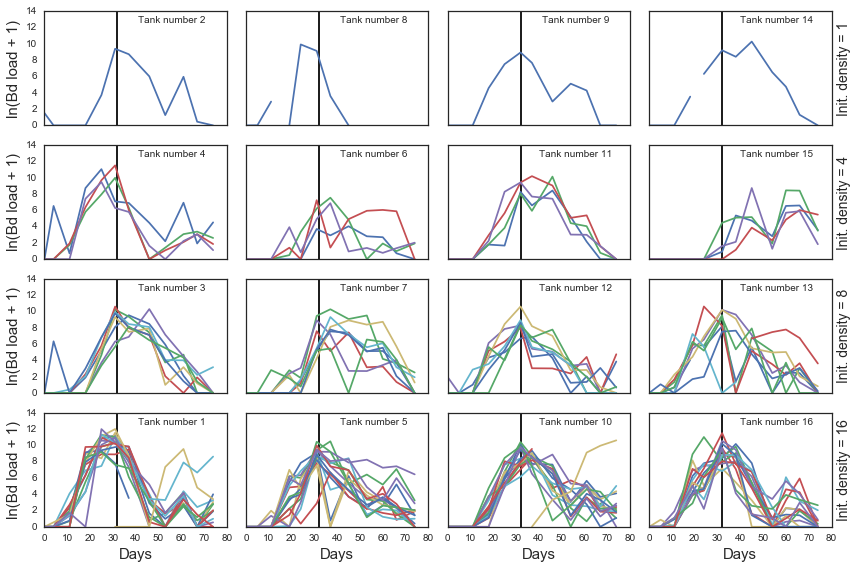

In [11]:
import seaborn as sns
sns.set_style("white")
fig, axes = plt.subplots(4, 4, figsize=(12, 8), sharex=True, sharey=True)
axes = axes.ravel()

tanks = dat.init_tank.unique()

for i, tank_id in enumerate(tanks):
    
    tdat = dat[dat.init_tank == tank_id]
    frogs = tdat.Indiv_id.unique()
    
    for frog in frogs:
        tfrog = tdat[tdat.Indiv_id == frog]
        axes[i].plot(tfrog.Day, np.log(tfrog.ZE + 1))
    
    if axes[i].is_last_row():
        axes[i].set_xlabel("Days", size=15)
    
    if axes[i].is_first_col():
        axes[i].set_ylabel("ln(Bd load + 1)", size=15)
        
    if axes[i].is_last_col():
        axes[i].yaxis.set_label_position("right")
        axes[i].set_ylabel("Init. density = {0}".format(tank_id.split("_")[0]), size=14)
    
    axes[i].text(0.7, 0.9, "Tank number {0}".format(tank_id.split("_")[1]), ha='center', transform=axes[i].transAxes)
    
    axes[i].vlines(32, 0, 14)
plt.tight_layout()
plt.savefig("../../results/observed_trajectories.pdf")